# Nota Técnica - Sociedade Brasileira de Pediatria
> Dados Epidemiológicos da COVID-19 em Pediatria

https://www.sbp.com.br/fileadmin/user_upload/22972b-NT_-_Dados_Epidem_COVID-19_em_Pediatria.pdf

## Objetivo do estudo
- Tentar reproduzir os resultados apresentados
- Fazer o mesmo gráfico ao longo dos meses ou das semanas epidemiológicas
- Fazer o mesmo gráfico com recorte por estados (ex. AM)

## Carregamento dos dados

Descrição das colunas: [dicionario-de-dados-srag-hospitalizado-27.07.2020-final.pdf](https://opendatasus.saude.gov.br/dataset/9f76e80f-a2f1-4662-9e37-71084eae23e3/resource/b3321e55-24e9-49ab-8651-29cf5c8f3179/download/dicionario-de-dados-srag-hospitalizado-27.07.2020-final.pdf)


In [1]:
#hide
# %run update_srag_database.py

In [3]:
#hide

import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from srag_functions import *

db_name = 'srag'
db_path = f'data/opendatasus/{db_name}.db'
conn = sql.connect(db_path)
df_srag = pd.read_sql(f'SELECT * FROM {db_name} WHERE ano >= 2020', conn)

In [4]:
#hide

assert df_srag.shape[1]==32

## Reprodução dos resultados

Gráfico 1: Proporção de hospitalizações e de mortes atribuídas à COVID-19 em crianças e adolescentes de 0 a 19 anos em 2020 e 2021

In [5]:
#hide

df_srag_repr = df_srag[df_srag['CLASSI_FIN'] == 'COVID-19'].copy()
df = df_srag_repr.groupby(['ano', 'faixa_etaria', 'EVOLUCAO']).size()

categories = [2020, 2021]
df_graf1 = pd.DataFrame(columns=[2020, 2021])
for cat in categories: 
    data = []
    try:
        n_internacoes_menores = df.loc[cat, '00-20'].sum()
    except KeyError:
        n_internacoes_menores = 0
    data.append(n_internacoes_menores / df.loc[cat].sum() * 100) # Percentual de internacoes
    try:
        n_obitos_menores = df.loc[cat, '00-20', 'obito'].sum()
    except KeyError:
        n_obitos_menores = 0
    data.append(n_obitos_menores / df.loc[cat, :, 'obito'].sum() * 100) # Percentual de internacoes
    df_graf1[cat] = data

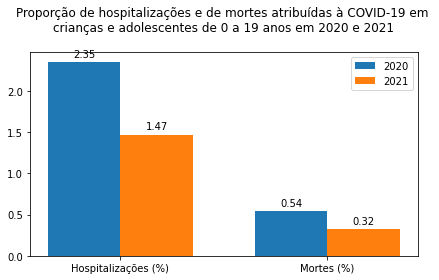

In [6]:
#hide

labels = ['Hospitalizações (%)', 'Mortes (%)']
x = np.arange(len(labels))  # the label locations
n = len(df_graf1.columns)
width = 0.7 / n
x0 = x - (n-1) * width / 2

fig, ax = plt.subplots()
fig.patch.set_facecolor((1,1,1))
for col in df_graf1.columns:
    rects = ax.bar(x0, np.around(df_graf1[col], 2), width, label=col)
    ax.bar_label(rects, padding=3)
    x0 = x0 + width

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Scores')
ax.set_title('Proporção de hospitalizações e de mortes atribuídas à COVID-19 em \ncrianças e adolescentes de 0 a 19 anos em 2020 e 2021\n')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

## Resultados por semana epidemiológica

In [7]:
#hide

dt_sin_pri = df_srag_repr['DT_SIN_PRI'].astype('datetime64')
df_srag_repr['semana_obito'] = (dt_sin_pri - dt_sin_pri.min()).astype('timedelta64[D]').astype(int) // 7 + 1
df = df_srag_repr.groupby(['semana_obito', 'faixa_etaria', 'EVOLUCAO']).size()

categories = df_srag_repr['semana_obito'].drop_duplicates().sort_values()
df_graf1 = pd.DataFrame()
for cat in categories: 
    data = []
    try:
        n_internacoes_menores = df.loc[cat, '00-20'].sum()
    except KeyError:
        n_internacoes_menores = 0
    data.append(n_internacoes_menores / (0.0001 + df.loc[cat].sum()) * 100) # Percentual de internacoes
    df_graf1[cat] = data
df_graf1 = df_graf1.T
df_graf1.columns = ['Hospitalizações']

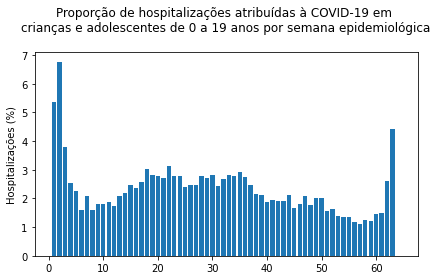

In [8]:
#hide

fig = plt.figure()
fig.patch.set_facecolor((1,1,1))
plt.bar(categories, df_graf1['Hospitalizações'])
# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Hospitalizações (%)')
plt.title('Proporção de hospitalizações atribuídas à COVID-19 em \ncrianças e adolescentes de 0 a 19 anos por semana epidemiológica\n')

fig.tight_layout()

plt.show()

In [9]:
#hide

dt_sin_pri = df_srag_repr['DT_SIN_PRI'].astype('datetime64')
dt_evoluca = df_srag_repr['DT_EVOLUCA'].astype('datetime64')
df_srag_repr['semana'] = (dt_evoluca - dt_sin_pri.min()).astype('timedelta64[D]').dropna().astype(int) // 7 + 1
df = df_srag_repr.groupby(['semana', 'faixa_etaria', 'EVOLUCAO']).size()

categories = df_srag_repr['semana'].drop_duplicates().dropna().sort_values()
df_graf1 = pd.DataFrame()
for cat in categories: 
    data = []
    try:
        n_obitos_menores = df.loc[cat, '00-20', 'obito'].sum()
    except KeyError:
        n_obitos_menores = 0
    try:
        n_obitos = df.loc[cat, :, 'obito'].sum()
    except KeyError:
        n_obitos = 0
    data.append(n_obitos_menores / (0.0001 + n_obitos) * 100) # Percentual de internacoes
    df_graf1[cat] = data
df_graf1 = df_graf1.T
df_graf1.columns = ['Mortes']

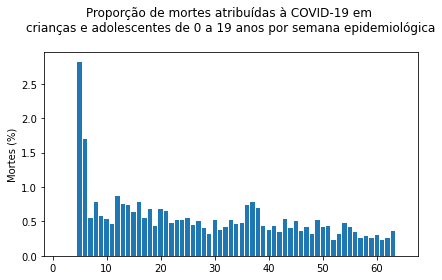

In [10]:
#hide

fig = plt.figure()
fig.patch.set_facecolor((1,1,1))
plt.bar(categories, df_graf1['Mortes'])
# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Mortes (%)')
plt.title('Proporção de mortes atribuídas à COVID-19 em \ncrianças e adolescentes de 0 a 19 anos por semana epidemiológica\n')

fig.tight_layout()

plt.show()